# What's Cooking Kaggle Challenge

Link: https://www.kaggle.com/c/whats-cooking/overview <br>
Medium Article: https://towardsdatascience.com/whats-cooking-categorizing-cuisines-with-nlp-ac44affe6b1d <br>
Github: https://github.com/reoneo97/Whats_Cooking <br>
In this notebook I'll be looking at the dataset from the Kaggle What's Cooking Challenge which is a supervised problem of predicting cuisines from ingredients list. The dataset is a .json file with only 2 important columns being the cuisine as well as the ingredients. In this notebook we will be doing exploratory data analysis followed by using some Natural Language Processing techniques to solve the problem. I will be using PyTorch to implement the deep learning model to learn the vector representations of the words.

## Contents: 

- Data Preprocessing
- Preliminary Model
- CBOW Model
- Evaluation
- Model with NLP Vectors



## Data Preprocessing


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("bright")
import torch.nn
import random


In [ ]:
#Loading the Data
df = pd.read_json("data/train.json")
df_test = pd.read_json("data/test.json")
print(len(df))
print(len(df_test))
df.head()


In [ ]:
#Different Cuisines present and their counts
df["cuisine"].value_counts()

In [ ]:
ingredients = df["ingredients"].tolist()
test_ingredients = df_test["ingredients"].tolist()
ingredients = ingredients + test_ingredients

# The Vector space has to include all ingredients from both Train and Test

In [ ]:
ingredients_dict = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict[ingredient] = ingredients_dict.get(ingredient,0)+ 1

ing_df = pd.DataFrame(data = ingredients_dict.values(),index = ingredients_dict.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
ing_df

As can be seen from the dataframe, there are currently 7137 differnt types of ingredients present in the dataset. However many of them are repeated but have a slightly different name in the recipe. (Eg. Garlic vs Chopped Garlic). Below you can see a list of stopwords which are redundant. This results in a reduction of the number of ingredients by around 200 which is relatively sizeable and will help the model learn better later by reducing the number of obscure words.

In [ ]:
stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list): 
    #Utility function to check if an ingredient is present in the list of recipes
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output
    
df["Vector"] = df["ingredients"].apply(convert_recipe) # Convert each recipe to a OHE Sparse Vector Form

Before looking at dimensionality reduction tools and 
Now that most of the preprocessing is done, traditional ML methods are used as a baseline effectiveness for the classification task so that we can compare the performance using Deep Learning.

In [ ]:
#Store all the vectors as a Matrix of M x 7137
mat = list(df["Vector"])
mat = np.array(mat)
mat.shape

## Principal Component Analysis and Preliminary Model
Because of the curse of dimensionality, training a model on this vector space will take way too long. For this we first use a linear dimensionality reduction tool PCA and later in the Natural Language Processing Section we can see how this actually compares with deep non-linear methods such as using the Continuous Bag of Words model later

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(32)
mat_32 = pca.fit_transform(mat)

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mat_32,df['cuisine'],
                                                    test_size=0.30)
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = svc.predict(X_test)
print(classification_report(y_test,predictions))
cr = classification_report(y_test,predictions,output_dict= True)

As we can see, the accuracy of this model is quite poor and that is to be expected. By reducing the number of dimensions with PCA, we lose a lot of information which translates to the model having significantly poorer performance. 

## Natural Language Processing

Now that we have seen how something like PCA can make sense of the data, we come to the interesting part which is to try to find a better vector representation of the words in a recipe.

Here we will use the Common Bag Of Words (CBOW) model in order to learn the representation of the words. The idea behind CBOW is to use the context of a word to learn what the word actually means. For example a sentence such as "I like to eat pasta", in order to learn the representation of the word "eat", we look at "pasta" and "like" as context words. In this case because the recipes are inherently unordered, the context words will be obtained randomly from the sample.

The implementation of this model is to use an autoencoder architecture where the One-Hot encoded word vectors are used in the model as inputs and encoded into the learnt representations and then the decoder will try to recreate the target word. 

Link: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

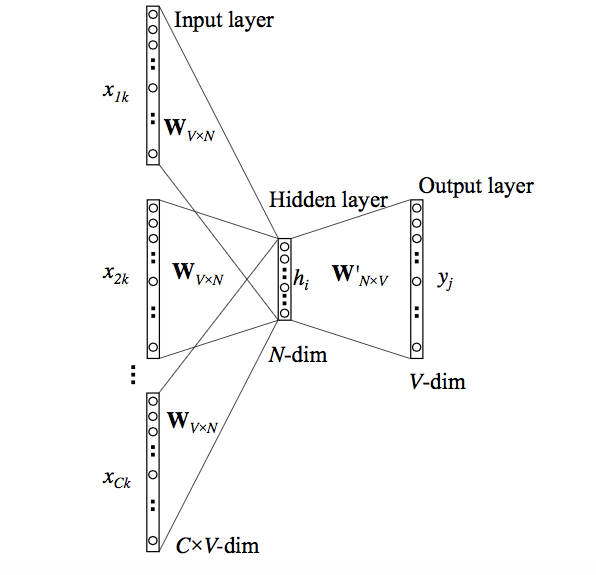
    

Recipe Sampling, Randomly choose 5 other ingredients that are in the same recipe and try to use the words to learn the representation of that word

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [ ]:
df = pd.concat([df,df_test]) # This is to train the Language Model on the entire set of ingredients

stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list):
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients2:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output
    
df["Vector"] = df["ingredients"].apply(convert_recipe) # Convert each recipe to a OHE Sparse Vector Form

In [ ]:
#Helper Functions
CONTEXT_SIZE = 5
#The sampling function to get context words from a recipe
def sample(recipe,ingredient,samples):
    '''
    Input: Recipe -> List of Ingredients
           Ingredient -> String 
           Samples: Int for number of samples
    Output: List of Strings
    '''
    recipe = recipe[:] #Copy the recipe to prevent alteration
    recipe.remove(ingredient)
    if len(recipe) < CONTEXT_SIZE+1:
        context = random.choices(recipe, k=samples) #With Replacement when they are insufficient ingredients in the recipe
    else: 
        context = random.sample(recipe, k=samples) #Without Replacement 
    return context
def createTensor(context):
    idxs = [ingredients_map[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class RecipeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
def loadData(dataCol,batch_size):
    samples = []
    for recipe in dataCol:
        for ingredient in recipe:
            if len(recipe) > 2:
                samples.append([sample(recipe,ingredient,CONTEXT_SIZE),ingredient])
    samples_idx = []
    for context,target in samples:
        target_idx = (torch.tensor([ingredients_map[target]], dtype=torch.long))
        samples_idx.append([createTensor(context),target_idx])
    
    sample_DS = RecipeDataset(samples_idx)
    print(samples_idx)
    train_loader = DataLoader(dataset=sample_DS, batch_size=batch_size, shuffle=True)
    return train_loader


In [ ]:
train_loader= loadData(df["ingredients"],64)

In [ ]:
VOCAB_SIZE = len(ingredients_dict2)
EMBED_DIM = 32

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #Transform to Lower Dimension Embeddings
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim = 1) #Sum over all the context
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out
    def getEmbeds(self,wordIdx):
        return self.embeddings(wordIdx)
        
cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)

In [ ]:
#Grid Search to find Ideal Learning Rate 

l_rs = [0.1,0.25,0.5,1,2]
#Code to find ideal learning Rate for the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
cbow.to(device)
loss_dict = {}
num_epochs = 25
BATCH_SIZE = 64
train_loader= loadData(df["ingredients"],BATCH_SIZE)
criterion = torch.nn.CrossEntropyLoss()


for l_r in l_rs:
    losses = []
    cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
    cbow.to(device)
    optimizer = torch.optim.SGD(cbow.parameters(), lr=l_r)
    iter_ = 0
    print("Learning Rate:",l_r)
    for epoch in range(num_epochs):
        total_loss = 0
        for i,(context,target) in enumerate(train_loader):
            
            context = context.to(device)
            target =target.to(device)
            optimizer.zero_grad()
            outputs = cbow(context)
            target = target.view(-1)
            #print(target.size(),outputs.size())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            iter_  += 1
            total_loss +=loss.item()
            if iter_%2500 ==0:
                print("Progress:",iter_/(num_epochs*len(train_loader))*100,"%")
    
        losses.append(total_loss)
    loss_dict[l_r] = losses


In [ ]:
for l_r,losses in loss_dict.items():
    plt.plot(losses,label = l_r)
plt.legend()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
cbow.to(device)
losses = []
num_epochs = 80
iter_ = 0
BATCH_SIZE = 128
learning_rate = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=learning_rate)  
for epoch in range(num_epochs):
    total_loss = 0
    if epoch%4 == 0:
        train_loader = loadData(df["ingredients"],BATCH_SIZE)
    for i,(context,target) in enumerate(train_loader):
        context = context.to(device)
        target =target.to(device)
        optimizer.zero_grad()
        outputs = cbow(context)
        target = target.view(-1)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        iter_  += 1
        total_loss +=loss.item()
        if iter_%500 ==0:
            print("Progress:",iter_/(num_epochs*len(train_loader))*100,"%")
    
    losses.append(total_loss)

print(losses)

In [ ]:
plt.plot(losses)



In [ ]:
cbow.to("cpu")
df = df[df["cuisine"].notna()]
ing_tensor_list = df["ingredients"].apply(createTensor).tolist()
embed_array = []
for recipe in ing_tensor_list:
    embeds = cbow.getEmbeds(recipe)
    embeds = embeds.mean(axis = 0).detach().numpy()
    embed_array.append(embeds)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
embed_array = np.array(embed_array)
nlp_vis = TSNE(n_components= 2,perplexity= 40).fit_transform(embed_array)

In [ ]:
set1 = list(df["cuisine"].value_counts().index[:10])
set2 = list(df["cuisine"].value_counts().index[10:])

In [ ]:
mat_vis =TSNE(n_components= 2,perplexity= 40).fit_transform(mat_32)

In [ ]:
sns.set_style("dark")
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":nlp_vis[:,0],"y" : nlp_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set1)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":nlp_vis[:,0],"y" : nlp_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set2)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":mat_vis[:,0],"y" : mat_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set1)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":mat_vis[:,0],"y" : mat_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set2)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Now that we have verified that the NLP model is working well, we can use it for our classification problem

In [ ]:

def getRecipeEmbedding(OH_tensor):
    return cbow.getEmbeds(OH_tensor).mean(axis =0).detach().numpy()
df["Tensor"] = df["ingredients"].apply(createTensor)
df["Embeds"] = df["Tensor"].apply(getRecipeEmbedding)

In [ ]:
mat_embeds = list(df["Embeds"])
mat_embeds = np.array(mat_embeds)

X_train, X_test, y_train, y_test = train_test_split(mat_embeds,df['cuisine'],
                                                    test_size=0.30)
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)

In [ ]:
predictions = svc.predict(X_test)
print(classification_report(y_test,predictions))
cr = classification_report(y_test,predictions,output_dict= True)

As can be seen the model improves significantly from using the NLP embeddings. Of course higher performance can be achieved by cleaning the dataset more and optimizing the hyperparameters of the SVC but this notebook is to mainly learn about the CBOW model and how to implement it using PyTorch. Enjoy!